In [100]:
import heapq
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
from tqdm import tqdm

class Event: # Copied from PCW
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule: # Copied from PCW   **Change: datetime module usage
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = datetime.datetime(2021, 1, 1, 8, 0, 0)  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval_sec, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + datetime.timedelta(seconds = interval_sec), function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [101]:
class Queue: 

    max_queue_len = float("-inf")
    
    def __init__(self, service_distribution):
        self.service_distribution = service_distribution
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0
        self.people_counter = 0
        self.waiting_times = []
        
    def add_customer(self, schedule):
        # Add the customer to the queue
        self.start_time = schedule.now
        self.start_time_man = schedule.now
        self.people_in_queue += 1
        self.people_counter += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
        
        if self.people_in_queue > Queue.max_queue_len: # Update the max queue length if needed
            Queue.max_queue_len = self.people_in_queue
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs()*60,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)
        
        # ADDING NEEDED FOR OUTPUT METRICS
        time_taken_per_cus = schedule.now - self.start_time # add the total waiting time
        self.waiting_times.append(time_taken_per_cus)

In [102]:
class BusSystem:
    
    def __init__(self, arrival_distribution, service_distribution, num_queues):
        self.queues = [Queue(service_distribution) for x in range(num_queues)]
        self.arrival_distribution = arrival_distribution

    def add_customer(self, schedule):
        '''Add customer to the SHORTEST queue'''
        # create list of tuples (queue, people in queue) to find the SHORTEST queue and add 
        # customer to it
        queues_lengths = [(queue, queue.people_in_queue) for queue in self.queues]
        # getting an index of the shortest queue
        shortest_queue_idx = queues_lengths.index(min(queues_lengths, key = lambda t: t[1]))
        # adding a customer to this specific queue
        self.queues[shortest_queue_idx].add_customer(schedule)
        # adding the next customer
        schedule.add_event_after(
            self.arrival_distribution.rvs()*60,
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs()*60, 
            self.add_customer)

In [103]:
def run_simulation(arrival_distribution, service_distribution, run_until, num_queues):
    schedule = Schedule()
    bus_system = BusSystem(arrival_distribution, service_distribution, num_queues)
    bus_system.run(schedule)
    
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
        
    # creating a storage for all waiting times generated across all queues
    all_wait_times = []
    for queue in bus_system.queues:
        all_wait_times += queue.waiting_times
    
    queue_max = Queue.max_queue_len
    Queue.max_queue_len = float("-inf") # updating for future experiment
    
    return bus_system, all_wait_times, queue_max

In [104]:
### A test to ensure that all works
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=2, scale=0.5)

bus_system = run_simulation(arrival_distribution, service_distribution, run_until = datetime.datetime(2021, 1, 2, 8, 0, 0), num_queues=1)

print("[OUTPUT CHECK] queue_max :", bus_system[2])

[OUTPUT CHECK] queue_max : 696


In [105]:
def run_experiment(arrival_rate_list, service_time_dist, run_until, num_trials, num_queues_list):
    '''
    Run an experiment with different arrival rates for an M/G/1 queue. By
    setting the service time distribution appropriately, you can also simulate
    M/D/1 and M/M/1 queues.
    '''
    
    # Record the mean and standard error of the mean for each experiment
    results_customer_per_stop_mean = []
    results_customer_per_stop_confint =[]
    
    results_wait_time_mean = []
    results_wait_time_confint = []
    
    results_max_queue_len_mean = []
    results_max_queue_len_confint = []

    for num_queues in num_queues_list:      
        # For each queue size, store data from trials so that we can take an average of it later on
        customer_per_stop_in_trials = []
        len_wait_times_in_trials = []
        len_max_queues_in_trials =[]
    
        for trial in range(num_trials):
            # run simulation in each trial and add needed metrics into the _in_trials_ lists defined above
            bus_queues, wait_times, max_queue  = run_simulation(arrival_distribution, service_distribution, run_until, num_queues)
            
            for queue in bus_queues.queues: 
                customer_per_stop_in_trials.append(queue.people_counter)
                
            total_wait_time_sec = datetime.timedelta(hours = 0, minutes = 0, seconds = 0)
            for wait_time in wait_times: 
                total_wait_time_sec += wait_time
                
            average_per_customer = total_wait_time_sec/len(wait_times)
            len_max_queues_in_trials.append(max_queue)
            len_wait_times_in_trials.append(average_per_customer.seconds/60)
            
        
        # Get mean of each of the metrics for each possible num_queues size
        # Add them into the lists defined above
        # These lists will be returned in this function and used for plotting later on
        
        average_customer_per_stop = np.mean(customer_per_stop_in_trials)
        results_customer_per_stop_mean.append(average_customer_per_stop)
        t = sts.sem(customer_per_stop_in_trials)
        results_customer_per_stop_confint.append(round((average_customer_per_stop + 1.96*t) - (average_customer_per_stop - 1.96*t), 4))
        
        average_max_queue_len = np.mean(len_max_queues_in_trials)
        results_max_queue_len_mean.append(average_max_queue_len)
        t = sts.sem(len_max_queues_in_trials)
        results_max_queue_len_confint.append(round((average_max_queue_len + 1.96*t) - (average_max_queue_len - 1.96*t), 4))
        
        average_wait_time = np.mean(len_wait_times_in_trials)
        results_wait_time_mean.append(average_wait_time)        
        t = sts.sem(len_wait_times_in_trials)
        results_wait_time_confint.append(round((average_wait_time + 1.96*t) - (average_wait_time - 1.96*t), 4))
        
    return results_customer_per_stop_mean, results_customer_per_stop_confint, results_wait_time_mean, results_wait_time_confint, results_max_queue_len_mean, results_max_queue_len_confint 


In [112]:
# Run the M/G/1 queue experiment
arrival_rate = 1 #lambda
average_service_time = 2
service_time_std = 0.5

arrival_distribution = sts.expon(scale=arrival_rate)
service_distribution = sts.norm(loc=average_service_time, scale=service_time_std)

run_until = datetime.datetime(2021,1,2,8, 0, 0)
num_trials = 10

num_queues_list = [i for i in range(1, 16)]

results_customer_per_stop_mean, results_customer_per_stop_confint, results_wait_time_mean, results_wait_time_confint, results_max_queue_len_mean, results_max_queue_len_confint = run_experiment(
    arrival_distribution, service_distribution, run_until, num_trials, num_queues_list)

print('M/G/1 experiment complete')

M/G/1 experiment complete


The expected value and a 95% confidence interval of the average passenger waiting time given  the number of buses on the route. Waiting time is defined as the duration between a passenger joining a queue at a bus stop and when the passenger gets on the bus.

No handles with labels found to put in legend.


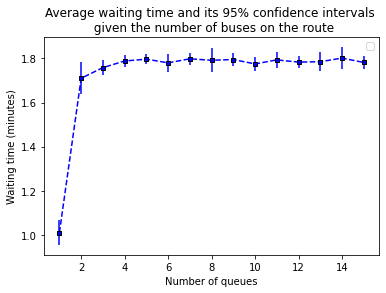

Number of queues | average waiting time
---------------------------------------
1                |    1.0100000000000002
2                |    1.7100000000000002
3                |    1.7583333333333333
4                |    1.7883333333333336
5                |    1.7966666666666664
6                |    1.78
7                |    1.7983333333333333
8                |    1.7916666666666665
9                |    1.795
10                |    1.775
11                |    1.7933333333333334
12                |    1.7833333333333337
13                |    1.7850000000000001
14                |    1.8016666666666665
15                |    1.7816666666666667


In [116]:
plt.figure()

# Make an error plot
plt.errorbar(num_queues_list, results_wait_time_mean, results_wait_time_confint, linestyle = "--", marker='s', ms = 4, color = 'blue', mec = 'black')
plt.xlabel('Number of queues')
plt.ylabel('Waiting time (minutes)')
plt.title("Average waiting time and its 95% confidence intervals \n given the number of buses on the route")
plt.legend()
plt.show()

print("Number of queues | average waiting time")
print("---------------------------------------")

for i in range(len(num_queues_list)): 
    print(num_queues_list[i], "               |   ", results_wait_time_mean[i]) 

The expected value and a 95% confidence interval of the maximum queue length at all bus stops during a day given the number of buses on the route.

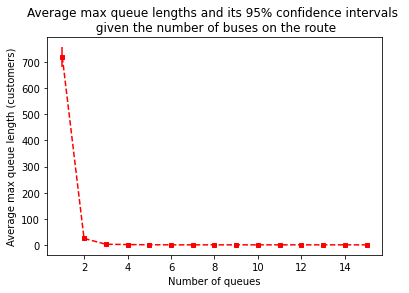

Number of queues | average max length
---------------------------------------
1                |    719.3
2                |    25.6
3                |    3.3
4                |    2.1
5                |    1.3
6                |    1.0
7                |    1.0
8                |    1.0
9                |    1.0
10                |    1.0
11                |    1.0
12                |    1.0
13                |    1.0
14                |    1.0
15                |    1.0


In [117]:
plt.figure()
plt.errorbar(num_queues_list, results_max_queue_len_mean, results_max_queue_len_confint, linestyle = "--", marker='s',  ms = 4, color = 'red')
plt.xlabel('Number of queues')
plt.ylabel('Average max queue length (customers)')
plt.title("Average max queue lengths and its 95% confidence intervals \n given the number of buses on the route")
plt.show()

print("Number of queues | average max length")
print("---------------------------------------")
for i in range(len(num_queues_list)): 
    print(num_queues_list[i], "               |   ", results_max_queue_len_mean[i]) 

The expected value and a 95% confidence interval of Average Queue Lengths.

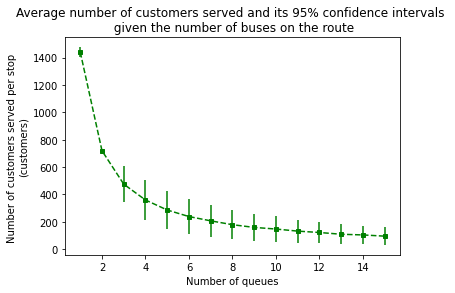

Number of queues | number of customer served per stop
-----------------------------------------------------------
1                |    1439.6
2                |    718.9
3                |    475.1666666666667
4                |    359.4
5                |    286.2
6                |    238.41666666666666
7                |    207.17142857142858
8                |    178.9625
9                |    159.1888888888889
10                |    147.27
11                |    132.05454545454546
12                |    122.05833333333334
13                |    109.18461538461538
14                |    104.17857142857143
15                |    95.3


In [118]:
plt.figure()
plt.errorbar(num_queues_list, results_customer_per_stop_mean, results_customer_per_stop_confint, linestyle = "--", marker='s', ms = 4, color = 'green')
plt.xlabel('Number of queues')
plt.ylabel('Number of customers served per stop \n(customers)')
plt.title("Average number of customers served and its 95% confidence intervals \n given the number of buses on the route")
plt.show()

print("Number of queues | number of customer served per stop")
print("-----------------------------------------------------------")
for i in range(len(num_queues_list)): 
    print(num_queues_list[i], "               |   ", results_customer_per_stop_mean[i]) 